In [ ]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
np.random.seed(42)

# Load images
image1 = cv2.imread('/content/set51.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set52.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt5.tif', cv2.IMREAD_GRAYSCALE)
pad_width = 2

# Pad images
image1_padded = np.pad(image1, pad_width, mode='constant')
image2_padded = np.pad(image2, pad_width, mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - 2:i + 3, j - 2:j + 3].flatten()

# Prepare data
data_image1 = []
data_image2 = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data_image1.append(neighbourhood1)
        data_image2.append(neighbourhood2)

data_image1 = np.array(data_image1)
data_image2 = np.array(data_image2)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data_image1[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data_image1[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.vstack((change_samples, unchanged_samples))
y = np.hstack((change_labels, unchanged_labels))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)

# Initialize and train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN
N1 = TN + FP

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) * 100 if (N0 + N1) != 0 else 0

# Print the results
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")

Correct Classification (CC): 111
False Alarms (FA): 7
Total Error (TE): 9
Probabilistic Conditional Correctness (PCC): 92.50%
Probability of False Alarm (PFA): 0.11
Probability of Total Error (PTE): 7.50


CNN

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set51.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set52.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt5.tif', cv2.IMREAD_GRAYSCALE)
pad_width = 2

# Pad images
image1_padded = np.pad(image1, pad_width, mode='constant')
image2_padded = np.pad(image2, pad_width, mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - 2:i + 3, j - 2:j + 3].reshape(5, 5, 1)  # Reshape to 5x5x1 for CNN input

# Prepare data
data = []
labels = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods to create a 5x5x2 input

# Convert data to a numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(5, 5, 2)),  # Input shape is 5x5x2
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN  # Total number of changed pixels
N1 = TN + FP  # Total number of unchanged pixels

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the results
print(f"Model accuracy on test set: {accuracy:.2f}")
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5270 - loss: 11.8091 - val_accuracy: 0.8778 - val_loss: 0.8803
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7077 - loss: 3.6659 - val_accuracy: 0.8000 - val_loss: 1.4592
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7320 - loss: 2.3039 - val_accuracy: 0.8222 - val_loss: 0.9947
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8330 - loss: 0.9129 - val_accuracy: 0.8667 - val_loss: 0.6238
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.8312 - val_accuracy: 0.9000 - val_loss: 0.2248
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8797 - loss: 0.5443 - val_accuracy: 0.8667 - val_loss: 0.4664
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9066 - loss: 0.3116 - val_accuracy: 0.8889 - val_loss: 0.2901
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9147 - loss: 0.3349 - val_accuracy: 0.9111 - val_loss: 0.2841


SVM

In [ ]:
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Set the random seed for reproducibility
np.random.seed(42)

# Load images
image1 = cv2.imread('/content/set21.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set22.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt2.tif', cv2.IMREAD_GRAYSCALE)
pad_width = 2

# Pad images
image1_padded = np.pad(image1, pad_width, mode='constant')
image2_padded = np.pad(image2, pad_width, mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - 2:i + 3, j - 2:j + 3].flatten()

# Prepare data
data_image1 = []
data_image2 = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data_image1.append(neighbourhood1)
        data_image2.append(neighbourhood2)

data_image1 = np.array(data_image1)
data_image2 = np.array(data_image2)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data_image1[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data_image1[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.vstack((change_samples, unchanged_samples))
y = np.hstack((change_labels, unchanged_labels))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train SVM classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN
N1 = TN + FP

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1)*100 if (N0 + N1) != 0 else 0

# Print the results
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")


Correct Classification (CC): 75
False Alarms (FA): 4
Total Error (TE): 15
Probabilistic Conditional Correctness (PCC): 83.33%
Probability of False Alarm (PFA): 0.08
Probability of Total Error (PTE): 16.67


Transformer

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MultiHeadAttention, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load images
image1 = cv2.imread('/content/set51.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/set52.tif', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('/content/gt5.tif', cv2.IMREAD_GRAYSCALE)
pad_width = 2

# Pad images
image1_padded = np.pad(image1, pad_width, mode='constant')
image2_padded = np.pad(image2, pad_width, mode='constant')

# Function to get neighborhood
def get_neighbourhood(image_padded, i, j):
    return image_padded[i - 2:i + 3, j - 2:j + 3].reshape(5, 5, 1)  # Reshape to 5x5x1 for CNN input

# Prepare data
data = []
for i in range(pad_width, image1_padded.shape[0] - pad_width):
    for j in range(pad_width, image1_padded.shape[1] - pad_width):
        neighbourhood1 = get_neighbourhood(image1_padded, i, j)
        neighbourhood2 = get_neighbourhood(image2_padded, i, j)
        data.append(np.dstack((neighbourhood1, neighbourhood2)))  # Stack the two neighborhoods to create a 5x5x2 input

# Convert data to a numpy array
data = np.array(data)

# Get change locations from ground truth
change_indices = np.argwhere(ground_truth == 0)
unchanged_indices = np.argwhere(ground_truth != 0)

# Ensure we have enough samples
if len(change_indices) < 150 or len(unchanged_indices) < 150:
    raise ValueError("Not enough change or unchanged locations in the ground truth image.")

# Randomly select 150 change and unchanged locations
selected_change_indices = np.random.choice(len(change_indices), size=150, replace=False)
selected_unchanged_indices = np.random.choice(len(unchanged_indices), size=150, replace=False)

# Extract samples and labels
change_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in change_indices[selected_change_indices]]
unchanged_samples = [data[(i - pad_width) * (image1_padded.shape[1] - 2 * pad_width) + (j - pad_width)] for i, j in unchanged_indices[selected_unchanged_indices]]

change_labels = [0] * 150
unchanged_labels = [1] * 150

# Combine data
X = np.array(change_samples + unchanged_samples)
y = np.array(change_labels + unchanged_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape patches for the Vision Transformer
num_patches = 50  # 5x5x2 = 50
X_train_patches = X_train.reshape(X_train.shape[0], num_patches, 1)
X_test_patches = X_test.reshape(X_test.shape[0], num_patches, 1)

# Vision Transformer Model
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_patches, embedding_dim, num_layers, num_heads):
        super(VisionTransformer, self).__init__()
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim
        self.patch_embedding = Dense(embedding_dim)
        self.positional_embedding = Embedding(input_dim=num_patches, output_dim=embedding_dim)
        self.attention_layers = [MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim) for _ in range(num_layers)]
        self.mlp_layers = [Sequential([
            Dense(embedding_dim, activation='relu'),  # Ensure MLP outputs match embedding_dim
            Dense(embedding_dim)
        ]) for _ in range(num_layers)]
        self.flatten = Flatten()
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        batch_size = tf.shape(x)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = self.patch_embedding(x)
        x += self.positional_embedding(positions)
        for i in range(len(self.attention_layers)):
            attention = self.attention_layers[i]
            mlp = self.mlp_layers[i]
            x = attention(x, x) + x  # Add residual connection
            x = mlp(x) + x  # Add residual connection
        x = self.flatten(x)
        return self.classifier(x)

# Instantiate the model
embedding_dim = 50  # Set the embedding dimension to match the input patch size
num_heads = 2
num_layers = 3

vit_model = VisionTransformer(num_patches=num_patches, embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads)

# Compile the model
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
vit_model.fit(X_train_patches, y_train, epochs=20, batch_size=16, validation_data=(X_test_patches, y_test))

# Predict on the test set
y_pred = vit_model.predict(X_test_patches)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Calculate N0 and N1
N0 = TP + FN  # Total number of changed pixels
N1 = TN + FP  # Total number of unchanged pixels

# Calculate metrics
PCC = ((TP + TN) / (N0 + N1)) * 100 if (N0 + N1) != 0 else 0
PFA = FP / N1 if N1 != 0 else 0
PTE = (FP + FN) / (N0 + N1) if (N0 + N1) != 0 else 0

# Print the results
print(f"Correct Classification (CC): {TP + TN}")
print(f"False Alarms (FA): {FP}")
print(f"Total Error (TE): {FP + FN}")
print(f"Probabilistic Conditional Correctness (PCC): {PCC:.2f}%")
print(f"Probability of False Alarm (PFA): {PFA:.2f}")
print(f"Probability of Total Error (PTE): {PTE:.2f}")


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.5668 - loss: 28.7426 - val_accuracy: 0.8556 - val_loss: 2.1658
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9020 - loss: 1.7067 - val_accuracy: 0.9000 - val_loss: 1.6657
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8741 - loss: 1.4405 - val_accuracy: 0.8778 - val_loss: 3.0736
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8731 - loss: 0.9420 - val_accuracy: 0.9222 - val_loss: 1.0343
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9116 - loss: 0.9415 - val_accuracy: 0.9222 - val_loss: 0.6681
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9392 - loss: 0.8981 - val_accuracy: 0.9222 - val_loss: 0.9167
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9507 - loss: 0.3023 - val_accuracy: 0.9111 - val_loss: 0.6553
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9492 - loss: 0.1219 - val_accuracy: 0.9222 - val_l

New Method

Training the model...
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.4393 - loss: 1.3079 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5221 - loss: 1.1837 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5347 - loss: 1.1164 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5627 - loss: 1.0545 - learning_rate: 0.0010
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6398 - loss: 0.9724 - learning_rate: 0.0010
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7126 - loss: 0.8992 - learning_rate: 9.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7724 - loss: 0.8496 - learning_rate: 8.1000e-04
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8114 - loss: 0.8089 - learning_rate: 7.2900e-04
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8361 - loss: 0.7757 - learning_rate: 6.5610

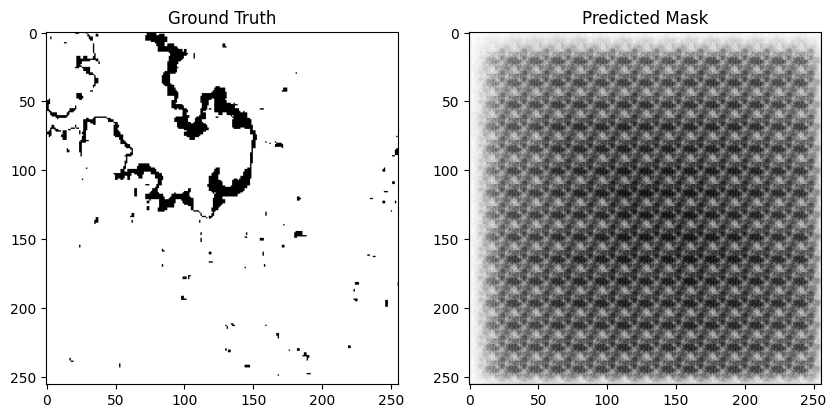

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load and Preprocess Images
def load_and_preprocess_images():
    target_size = (256, 256)
    image1 = cv2.imread('/content/set51.tif', cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread('/content/set52.tif', cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread('/content/gt5.tif', cv2.IMREAD_GRAYSCALE)

    # Resize images
    image1 = cv2.resize(image1, target_size, interpolation=cv2.INTER_LINEAR)
    image2 = cv2.resize(image2, target_size, interpolation=cv2.INTER_LINEAR)
    ground_truth = cv2.resize(ground_truth, target_size, interpolation=cv2.INTER_NEAREST)

    # Stack and normalize
    X = np.stack((image1, image2), axis=-1) / 255.0
    X = np.expand_dims(X, axis=0)

    # Binary ground truth mask
    y = (ground_truth > 0).astype(np.float32)
    y = np.expand_dims(y, axis=(0, -1))

    return X, y

# ASPP Module
def aspp_module(x):
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, x.shape[-1]))(pool)
    pool = layers.Conv2D(256, 1, padding="same", activation="relu")(pool)
    pool = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation="bilinear")(pool)

    conv1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    conv3 = layers.Conv2D(256, 3, dilation_rate=3, padding="same", activation="relu")(x)
    conv6 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", activation="relu")(x)
    conv9 = layers.Conv2D(256, 3, dilation_rate=9, padding="same", activation="relu")(x)

    output = layers.Concatenate()([pool, conv1, conv3, conv6, conv9])
    output = layers.Conv2D(256, 1, padding="same", activation="relu")(output)

    return output

# Attention Gate
def attention_gate(x, g):
    filters = x.shape[-1]

    # 1x1 Convolutions to match dimensions
    theta_x = layers.Conv2D(filters, 1, padding="same")(x)
    phi_g = layers.Conv2D(filters, 1, padding="same")(g)

    # Add and apply ReLU activation
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation("relu")(add)

    # 1x1 Convolution to compute attention map
    psi = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(relu)

    # Scale the input feature map
    return layers.Multiply()([x, psi])

# T-UNet Model with ASPP and Attention Gates
def t_unet_with_aspp_and_attention():
    inputs = layers.Input(shape=(256, 256, 2))

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(0.1)(conv1)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(2)(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(2)(conv2)

    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(0.3)(conv3)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(2)(conv3)

    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Dropout(0.4)(conv4)
    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(2)(conv4)

    # Bottleneck with ASPP
    bottleneck = aspp_module(pool4)

    # Decoder with Attention Gates
    up4 = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(bottleneck)
    gated4 = attention_gate(conv4, up4)
    concat4 = layers.Concatenate()([up4, gated4])
    conv5 = layers.Conv2D(512, 3, activation="relu", padding="same")(concat4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Dropout(0.4)(conv5)

    up3 = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(conv5)
    gated3 = attention_gate(conv3, up3)
    concat3 = layers.Concatenate()([up3, gated3])
    conv6 = layers.Conv2D(256, 3, activation="relu", padding="same")(concat3)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Dropout(0.3)(conv6)

    up2 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(conv6)
    gated2 = attention_gate(conv2, up2)
    concat2 = layers.Concatenate()([up2, gated2])
    conv7 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat2)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Dropout(0.2)(conv7)

    up1 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(conv7)
    gated1 = attention_gate(conv1, up1)
    concat1 = layers.Concatenate()([up1, gated1])
    conv8 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat1)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Dropout(0.1)(conv8)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(conv8)

    return Model(inputs, outputs)

# Loss Functions: Combined Binary Crossentropy and Dice Loss
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return bce + dice_loss

# Learning Rate Scheduler
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

# Function to calculate the metrics
def calculate_metrics(y_true, y_pred):
    # Convert to binary values (0 or 1)
    y_true = np.round(y_true).flatten()
    y_pred = np.round(y_pred).flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # True Positive Rate (PCC)
    pcc = tp / (tp + fn) if (tp + fn) != 0 else 0

    # False Positive Rate (PFA)
    pfa = fp / (fp + tn) if (fp + tn) != 0 else 0

    # Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0

    # Recall (same as PCC in this binary case)
    recall = pcc

    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, pcc, pfa, precision, recall, f1_score

# Main Execution
if __name__ == "__main__":
    # Load Data
    X, y = load_and_preprocess_images()

    # Build and Compile Model
    model = t_unet_with_aspp_and_attention()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=combined_loss, metrics=["accuracy"])

    # Callbacks
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the Model
    print("Training the model...")
    history = model.fit(X, y, epochs=30, verbose=1, callbacks=[lr_scheduler])

    # Predict
    predictions = model.predict(X)

    # Calculate metrics
    accuracy, pcc, pfa, precision, recall, f1_score = calculate_metrics(y, predictions)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"PCC (True Positive Rate): {pcc:.4f}")
    print(f"PFA (False Positive Rate): {pfa:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Visualize the Mask Prediction
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth")
    plt.imshow(np.squeeze(y), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(predictions), cmap='gray')

    plt.show()


Unet